In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10, 5]
import random
import geopandas
from shapely.geometry import Point

import time
import pathlib

import sklearn.preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

import sys
import importlib
sys.path.append('../NYC')
#%load_ext autoreload (if you need to edit the module while working on this notebook)
import data_preprocess 
import nyc_ml_err_plots 
import nyc_ml_models

importlib.reload(data_preprocess)
importlib.reload(nyc_ml_err_plots)
importlib.reload(nyc_ml_models)
#print(dir(data_prep))

<module 'nyc_ml_models' from '../NYC\\nyc_ml_models.py'>

In [2]:
nyc_4_loc = '../data/interim/4_nyc_EDA.csv'
df = pd.read_csv(nyc_4_loc, parse_dates = ['pickup_datetime', 'dropoff_datetime'])

In [3]:
df['pickup_weekday'] = df.pickup_datetime.dt.dayofweek

In [4]:
tp_df = df.sample(200000, random_state = 42).reset_index(drop = True)

In [5]:
cols_to = ['vendorid', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday',
              'holiday', 'distance_hav', 'bearing', 'pickup_zone_cluster', 'dropoff_zone_cluster',
              'trip_duration']

                    'learning_rate': [int(x) for x in np.linspace(0.05, 0.2, 6, endpoint = False)],
                    'subsample': [0.76, 0.78, 0.8, 0.82, 0.84],

# Further Tuning XGBoost

In [47]:
# generating the model
xg_regression = xgb.XGBRegressor(subsample = 0.8, 
                                 reg_alpha = 0.005, 
                                 n_estimators = 246, 
                                 min_child_weight =  3,
                                 max_depth = 6, 
                                 learning_rate = 0.1, 
                                 gamma =  0.0, 
                                 colsample_bytree =  1,
                                 eval_metric = 'rmse',
                                 objective = 'reg:squarederror')

params_xg = {
                    'n_estimators': [int(x) for x in np.linspace(100, 300, 30, endpoint = False)],
                    'learning_rate': [0.05, 0.075, 0.09, 0.1, 0.125, 0.15, 0.2],
                    'subsample': [0.76, 0.78, 0.8, 0.82, 0.84]
                    }

In [48]:
dict_err = {}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished
C:\Users\ppawar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \





============================= XGBRegressor =================================

It takes 656.314 seconds for tuning 
BEST PARAMS {'subsample': 0.84, 'n_estimators': 286, 'learning_rate': 0.2}
It takes 73.288 seconds for fitting
train score:  0.8683959817600826  
test score:  0.8174124144727896

Error metrics for model Tuned XGBoost
RMSE or Root mean squared error: 273.52
RMSLE or Root mean squared log error: 0.33
Variance score: 0.82
Mean Absolute Error: 178.70
Mean Absolute Percentage Error: 26.45 %

Plotting Predicted vs Observed trip duration in seconds

Plotting Predicted vs Residuals

Plotting feature importance


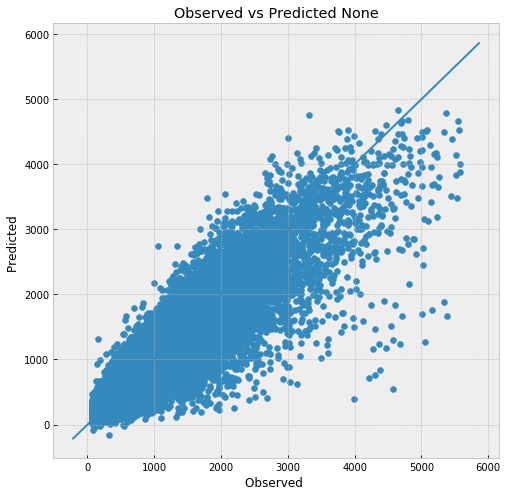

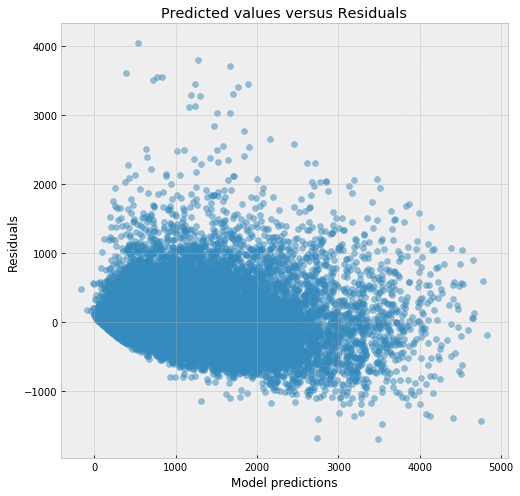

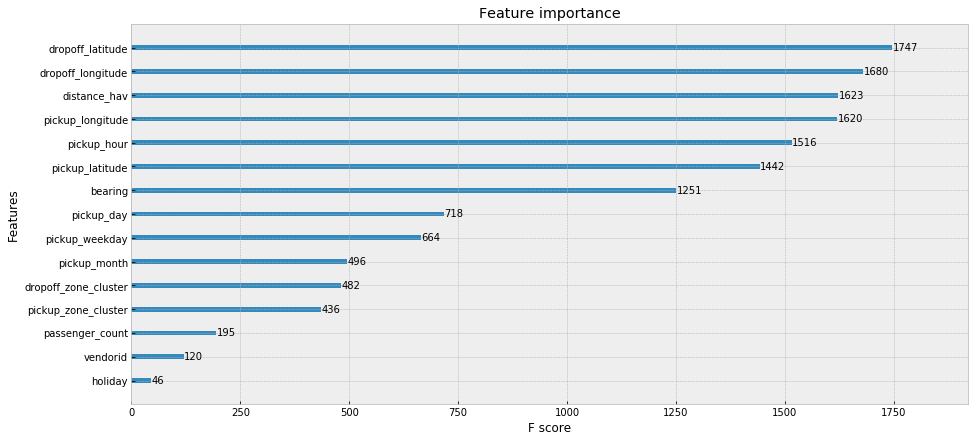

In [49]:
model_reg, X_train_x, y_train_x, X_test_x, y_test_x = nyc_ml_models.do_regression(xg_regression, params_xg, 
                                                        tp_df[cols_to], dict_err,
                                                        model_name = "Tuned XGBoost", test_size = 0.3, fourier = False)

xg_regression.fit(tp_df[cols_to].drop('trip_duration', axis = 1), tp_df.trip_duration)

nyc_ml_err_plots.error_metrics(xg_regression.predict(tp_df[cols_to].drop('trip_duration', axis = 1)), 
                               tp_df.trip_duration, dict_err, 
                               model_name = "Best XGB", test = True)

# Removing the flattening from RF output by increasing max_depth

In [64]:
params_rf = {
                  'max_depth' : list(range(7, 18)),
                  'n_estimators': [int(x) for x in np.linspace(350, 450, 30, endpoint=False)]
                 }

rf_reg = RandomForestRegressor()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.5min finished





============================= RandomForestRegressor =================================

It takes 3177.327 seconds for tuning 
BEST PARAMS {'n_estimators': 403, 'max_depth': 17}
It takes 445.885 seconds for fitting
train score:  0.9253150013411334  
test score:  0.7996550586528488

Error metrics for model Tuned RF reg
RMSE or Root mean squared error: 286.52
RMSLE or Root mean squared log error: 0.34
Variance score: 0.80
Mean Absolute Error: 189.02
Mean Absolute Percentage Error: 28.93 %

Plotting Predicted vs Observed trip duration in seconds

Plotting Predicted vs Residuals

Plotting feature importance


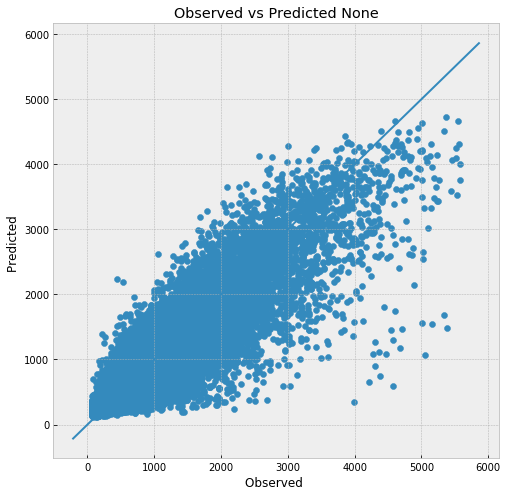

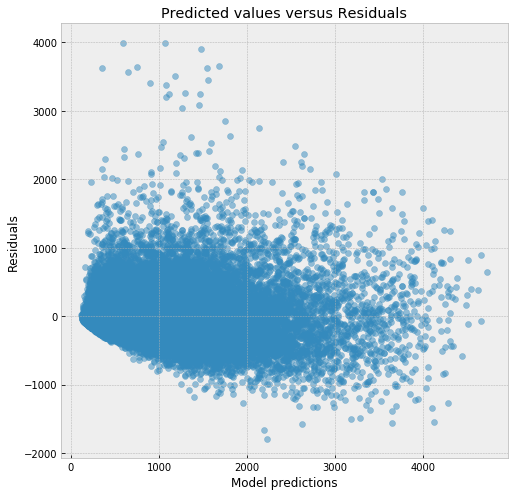

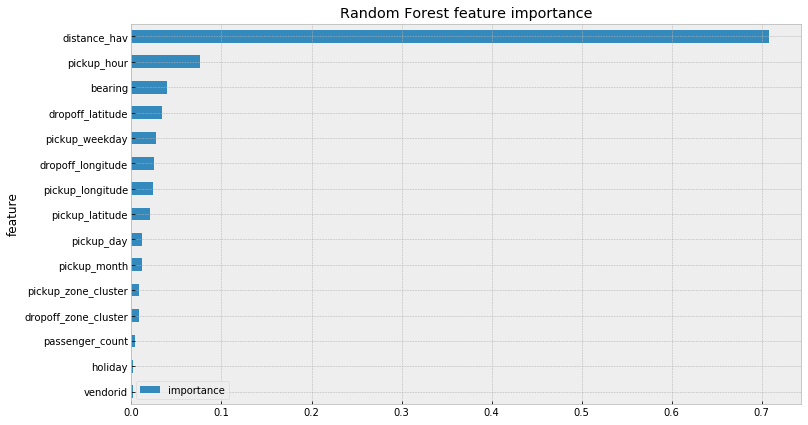

In [65]:
modelrf, X_trainrf, y_trainrf, X_testrf, y_testrf = nyc_ml_models.do_regression(rf_reg, params_rf, 
                                                                                tp_df[cols_to], dict_err,
                                                        model_name = "Tuned RF reg", test_size = 0.3, fourier = False)

# Saving the ML models

In [66]:
import pickle

In [68]:
filename = 'trained_models/tuned_xgboost_2.sav'
pickle.dump(model_reg, open(filename, 'wb'))

In [69]:
# how to load the model again
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_x, y_test_x)
print(result)

0.8174124144727896


In [71]:
filename_RF = 'trained_models/max_depth_RF_2.sav'
pickle.dump(rf_reg, open(filename_RF, 'wb'))